In [1]:
import scipy.linalg as la
from scipy.special import factorial
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import numpy as np
from helper_functions.grape_functions import *
from main_grape.Grape import Grape
%pylab inline
import h5py


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
state_transfer = True

#Defining time scales
total_time = 100.0
steps = 12000

#Defining H0
qubit_state_num = 5

alpha = 0.225
freq_ge = 3.5#GHz
ens = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(np.arange(0,qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)

mode_state_num = 25
qm_g =2*np.pi*0.1
mode_freq = 3.9 #GHz
mode_ens = np.array([ 2*np.pi*ii*(mode_freq) for ii in np.arange(mode_state_num)])
M_x = np.diag(np.sqrt(np.arange(1,mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,mode_state_num)),-1)
M_y = (0+1j) *(np.diag(np.sqrt(np.arange(1,mode_state_num)),1)-np.diag(np.sqrt(np.arange(1,mode_state_num)),-1))
M_z   = np.diag(np.arange(0,mode_state_num))
H_m = np.diag(mode_ens)
I_m = np.identity(mode_state_num)

H0 = np.kron(H_q,I_m) + np.kron(I_q,H_m) +\
        + qm_g*np.kron(Q_x,M_x) 
    
#Defining control Hs

XI = np.kron(Q_x,I_m)
YI = np.kron(Q_y,I_m)
ZI = np.kron(Q_z,I_m)
IX = np.kron(I_q,M_x)
IY = np.kron(I_q,M_y)
IZ = np.kron(I_q,M_z)

Hops = [XI,ZI]
ops_max_amp = [2.0,2.0]
Hnames =['xi','zi']

#Defining the coherent state

def coherent_state(beta):
    coeffs = []
    pre_factor = np.exp((-(np.abs(beta))**2)/2)
    for ii in range(mode_state_num):
        coeff = pre_factor * beta**ii /(np.sqrt(factorial(ii)))
        coeffs.append(coeff)
    return coeffs


beta = 3.0
coeffs_1 = coherent_state(beta)
coeffs_2 = coherent_state(- beta)
coeffs_3 = coherent_state((0+1j)*beta)
cat_coeffs = (1/np.sqrt(2)) * np.add(coeffs_1,coeffs_2)

cat= cat_coeffs
cat=np.append(cat,np.zeros((qubit_state_num-1)*mode_state_num))

a=0
for k in cat:
    a = a+ np.abs(k)**2

#Defining dressed info

is_dressed = True

w_c, v_c, dressed_id = get_dressed_info(H0)

dressed_info = {'dressed_id':dressed_id, 'eigenvectors':v_c,\
               'eigenvalues':w_c, 'is_dressed':is_dressed}


#Defining states to include in the drawing of occupation
states_draw_list = range(mode_state_num)
states_draw_names = []
for ii in range (mode_state_num):
    states_draw_names.append('0_'+str(ii))
    
    
#Defining target

from helper_functions.grape_functions import get_state_index
g0 = v_c[:,get_state_index(0,dressed_id)]
if not state_transfer:
    
    if is_dressed:
        cat_d = np.zeros(mode_state_num*qubit_state_num)
    
        for ii in range(len(cat)):
            cat_d = cat_d + cat[ii] * v_c[:,get_state_index(ii,dressed_id)]
    else:
        cat_d = cat
   
    print "cat_d inner product: " + str(np.inner(cat_d,cat_d))
    print "g0 inner product: " + str(np.inner(g0,g0))
    U =  np.outer(cat_d,g0)

else:
    if is_dressed:
        cat_d = np.zeros(mode_state_num*qubit_state_num)
    
        for ii in range(len(cat)):
            cat_d = cat_d + cat[ii] * v_c[:,get_state_index(ii,dressed_id)]
    else:
        cat_d = cat
        
    U = [cat_d]
    
#Defining Concerned states (starting states)
psi0=[0]

#Defining states to include in the drawing of occupation
states_draw_list = range(mode_state_num)
states_draw_names = []
for ii in range (mode_state_num):
    states_draw_names.append('g_'+str(ii))



#Defining convergence parameters
max_iterations = 5000
decay = 2000 #max_iterations/2
convergence = {'rate':0.01, 'update_step':10, 'max_iterations':max_iterations,\
               'conv_target':1e-3,'learning_rate_decay':decay}




# Defining reg coeffs

states_forbidden_list = []

for ii in range(mode_state_num):
    forbid_state = (qubit_state_num-1)*mode_state_num+ii
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
for ii in range(mode_state_num):
    forbid_state = (qubit_state_num-2)*mode_state_num+ii
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
# for ii in range(mode_state_num):
#     forbid_state = (qubit_state_num-3)*mode_state_num+ii
#     if not forbid_state in states_forbidden_list:
#         states_forbidden_list.append(forbid_state)
        
for ii in range(qubit_state_num):
    forbid_state = ii*mode_state_num + (mode_state_num-1)
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
for ii in range(qubit_state_num):
    forbid_state = ii*mode_state_num + (mode_state_num-2)
    if not forbid_state in states_forbidden_list:
        states_forbidden_list.append(forbid_state)
        
reg_coeffs = {'envelope' : 0.0, 'dwdt':0.00001,'d2wdt2':0.00001*0.0001, 'forbidden':100,
             'states_forbidden_list': states_forbidden_list,'forbid_dressed':True}

In [3]:
with h5py.File('/home/nelson/Simulations/GRAPE-Data/cat/00132_cat.h5','r') as hf:
    last_u0 = np.array(hf['uks'])[-1]

time_new = np.linspace(0,100,12000,endpoint=False)
time_old = np.linspace(0,100,20000,endpoint=False)

u0_0_temp = np.interp(time_new,time_old,last_u0[0])
u0_1_temp = np.interp(time_new,time_old,last_u0[1])

u0 = np.array([u0_0_temp,u0_1_temp])

#u0 = None

#u0 = last_u0

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Error = 9.92e-04
Total time is 1167.92183208


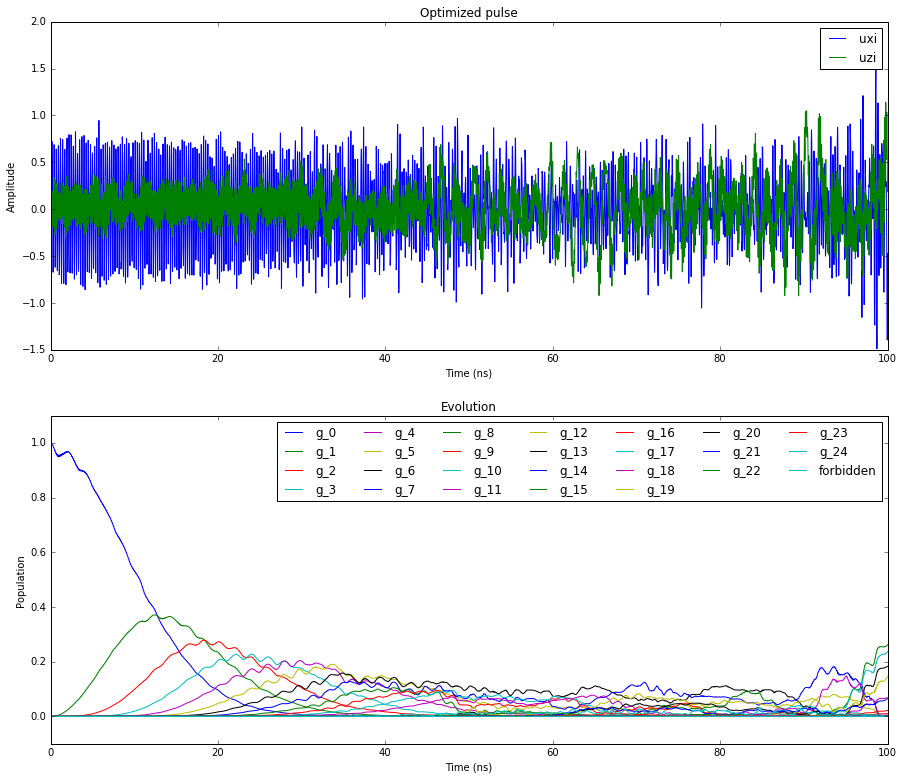

In [4]:
uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],  
                    state_transfer=state_transfer, 
                    show_plots =False,  
       Taylor_terms = [20,0] , method = 'L-BFGS-B',switch = False,initial_guess = u0,maxA = ops_max_amp
                    ,reg_coeffs = reg_coeffs,dressed_info=dressed_info,file_name = "cat"
                    , data_path = "/home/nelson/Simulations/GRAPE-Data/cat")